# labs_bmi_bp_data_preprocessing_2.ipynb

**Primary Analyst:** Patrick Wu

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

# Set seed
np.random.seed(10011)

## Helper functions

In [2]:
# create function looking at top X number of labs
def top_labs(labs_df,num_labs=10):
    
    """function takes in lab in dataframe format and outputs 
    
        :param labs_df = lab dataframe with columns = {'RUID','Lab_name','Lab_date','Lab_value'}
        :param num_labs = top X of desired top labs to output from function, default = top 10
        
        :return = 
            top_num_labs: pandas dataframe with columns {'Lab_name','counts'} that contains only labs from top number of desired labs
            top_pt_labs: pandas dataframe with columns {'RUID', 'Lab_name', 'Lab_date','Lab_value'} that contains only labs from top number of desired labs
    """
    # preprocess lab dataframe to get sorted labs
    top_labs = pd.DataFrame(labs_df[['Lab_name']].groupby(['Lab_name']).size()).reset_index()
    top_labs.columns = ['Lab_name','counts']
    top_labs1 = top_labs.sort_values(by='counts',ascending=False)
    
    # get dataframe with columns = {'Lab_name', 'counts'}
    top_num_labs = top_labs1.iloc[0:int(num_labs),:]
    
    # create dataframe with only labs matching top labs
    top_pt_labs = labs_df[labs_df['Lab_name'].isin(top_num_labs['Lab_name'])]
    
    return top_num_labs, top_pt_labs

In [3]:
# write function to clean labs, to remove non-numeric values, etc.

def cleanLabs(labsdf):
    
    # sort labs dataframe to identify non-numeric values
    cleanlabs_df = labsdf.sort_values(by='lab_value',ascending=False)
    
    # convert non-numeric values to 'NaN'
    cleanlabs_df['lab_value'] = pd.to_numeric(cleanlabs_df['lab_value'],errors='coerce')
    
    # remove rows with NaN for Lab_value
    cleanlabs_df = cleanlabs_df[~cleanlabs_df['lab_value'].isna()]
    
    # return cleaned up labs dataframe
    return cleanlabs_df

In [4]:
# write function to clean labs, to remove non-numeric values, etc.
# note that this differs from the cleanLabs() function, as rows with NaN are NOT removed

def cleanLabs1(labsdf):
    
    # sort labs dataframe to identify non-numeric values
    cleanlabs_df = labsdf.sort_values(by='lab_value',ascending=False)
    
    # convert non-numeric values to 'NaN'
    cleanlabs_df['lab_value'] = pd.to_numeric(cleanlabs_df['lab_value'],errors='coerce')
    
    # return cleaned up labs dataframe
    return cleanlabs_df

In [5]:
# write function that returns merged table for labs with base_table
def stat_values_labs(labs_df, base_table):
    
    # merge cleaned up labs df with match 'ruid' and 'hospital_day' with base table
    labs_merged = pd.merge(labs_df, base_table, how='right', right_on=['ruid','hospital_day'], left_on=['ruid','lab_date'])
    
    # return merged df
    return labs_merged

In [6]:
# function to detect outliers in lab values, here 1% and 99% percentile are defined as outliers

def outlier_detection(lab_dataframe, lab_name):
    
    lab_df1 = lab_dataframe[lab_dataframe['lab_name']==lab_name]
    
    _ = plt.hist(lab_df1['lab_value'])
    
    lab_99 = np.nanpercentile(lab_df1['lab_value'], 99, interpolation='midpoint')
    lab_1 = np.nanpercentile(lab_df1['lab_value'], 1, interpolation='midpoint')
    
    print("99% percentile for ",lab_name,":",lab_99)
    print("1% percentile for ",lab_name,":",lab_1)

In [7]:
dir = '../data/'

## Aim #1: for each lab, get summary stats for each visit

In [8]:
labs = pd.read_csv(dir+'labs_cleaned.csv',dtype={'ruid': str})

1) get median for each lab for each `ruid-visit_id` combination

In [10]:
labs=labs[['ruid','visit_id','hospital_day','lab_name','lab_value']]

In [11]:
labs.head()

,ruid,visit_id,hospital_day,lab_name,lab_value
0,53732537,5,2015-04-25,Ca,9.4
1,53735977,3,2014-03-15,Ca,8.5
2,53733675,5,2014-02-09,Ca,9.8
3,53728759,4,2013-05-30,Ca,8.1
4,53735479,1,2013-12-30,Ca,8.0


In [12]:
labs_median = pd.pivot_table(labs, values='lab_value', index=['ruid', 'visit_id'], columns=['lab_name'], aggfunc=np.median).reset_index()

In [13]:
labs_median.isna().sum()

lab_name
ruid           0
visit_id       0
AN-GAP      1913
BUN         1918
CO2         1728
Ca          2901
Cl          1899
Creat       1647
GluBed      9964
Gluc        1791
Hgb         1815
K           1518
MCH         2053
MCHC        1841
MCV         2049
Na          1692
PCV          673
Plt-Ct      1556
RBC         1819
RDW         1897
WBC         1849
dtype: int64

In [14]:
labs_median.head()

lab_name,ruid,visit_id,AN-GAP,BUN,CO2,Ca,Cl,Creat,GluBed,Gluc,...,K,MCH,MCHC,MCV,Na,PCV,Plt-Ct,RBC,RDW,WBC
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,4.40,29.00,32.00,91.0,136.0,32.0,334.0,4.41,14.10,16.0
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,4.45,28.00,33.10,85.0,135.0,39.0,291.5,4.54,18.20,12.3
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,3.90,28.35,32.80,86.5,139.0,38.0,308.0,4.39,16.55,10.5
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,4.00,26.20,31.50,83.0,135.0,38.0,274.0,4.57,15.50,10.3
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,4.10,25.50,31.35,81.5,139.0,36.0,330.0,4.45,15.70,10.0


In [15]:
# convert all column names to lowercase
labs_median.columns = [x.lower() for x in labs_median.columns]

# add 'median' string to lab names
labs_median_cols = labs_median.columns
labs_median_cols = labs_median_cols.tolist()[2:]
labs_median_cols = [x+'_median' for x in labs_median_cols]

# change column names
labs_median.columns = ['ruid','visit_id'] + labs_median_cols

In [16]:
labs_median.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,k_median,mch_median,mchc_median,mcv_median,na_median,pcv_median,plt-ct_median,rbc_median,rdw_median,wbc_median
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,4.40,29.00,32.00,91.0,136.0,32.0,334.0,4.41,14.10,16.0
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,4.45,28.00,33.10,85.0,135.0,39.0,291.5,4.54,18.20,12.3
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,3.90,28.35,32.80,86.5,139.0,38.0,308.0,4.39,16.55,10.5
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,4.00,26.20,31.50,83.0,135.0,38.0,274.0,4.57,15.50,10.3
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,4.10,25.50,31.35,81.5,139.0,36.0,330.0,4.45,15.70,10.0


2) get 5th percentile for each lab for each ruid-visit_id combination

In [17]:
labs_5p = pd.pivot_table(labs, values='lab_value', index=['ruid', 'visit_id'], columns=['lab_name'], aggfunc=lambda x: np.percentile(x, 5)).reset_index()

/anaconda3/envs/bios8366/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [18]:
labs_5p.tail()

lab_name,ruid,visit_id,AN-GAP,BUN,CO2,Ca,Cl,Creat,GluBed,Gluc,...,K,MCH,MCHC,MCV,Na,PCV,Plt-Ct,RBC,RDW,WBC
18854,53736421,5,11.00,8.25,23.35,9.50,102.2,0.6115,NaN,84.15,...,4.225,30.460,31.665,96.00,140.15,35.25,254.70,3.6365,13.700,6.520
18855,53736421,6,8.20,9.20,25.50,8.22,100.2,0.5920,NaN,48.70,...,3.110,31.790,32.220,97.10,140.10,32.10,264.20,3.2900,13.900,9.500
18856,53736421,7,9.15,19.35,31.15,9.50,104.3,1.4455,NaN,116.30,...,3.410,31.470,30.895,100.10,NaN,30.10,306.90,2.9680,14.115,8.700
18857,53736421,8,8.45,16.15,24.15,8.41,102.0,0.7765,73.0,64.75,...,3.730,31.800,31.715,99.15,141.15,26.40,446.25,2.6665,13.530,7.785
18858,53736422,0,NaN,14.85,19.00,6.83,NaN,0.8150,NaN,73.10,...,3.200,28.805,30.200,88.10,NaN,22.15,83.30,2.3650,14.605,8.820


In [19]:
labs_5p.columns

Index(['ruid', 'visit_id', 'AN-GAP', 'BUN', 'CO2', 'Ca', 'Cl', 'Creat',
       'GluBed', 'Gluc', 'Hgb', 'K', 'MCH', 'MCHC', 'MCV', 'Na', 'PCV',
       'Plt-Ct', 'RBC', 'RDW', 'WBC'],
      dtype='object', name='lab_name')

In [20]:
# check that the function gives 5th percentile
labs.loc[(labs['ruid']=='53736421')&(labs['visit_id']==8)&(labs['lab_name']=='RBC')]

,ruid,visit_id,hospital_day,lab_name,lab_value
597131,53736421,8,2014-04-14,RBC,2.65
601019,53736421,8,2014-04-12,RBC,3.24
626899,53736421,8,2014-04-15,RBC,2.76
627903,53736421,8,2014-04-13,RBC,3.05


yes it does

In [21]:
# convert all column names to lowercase
labs_5p.columns = [x.lower() for x in labs_5p.columns]

# add 'median' string to lab names
labs_5p_cols = labs_5p.columns
labs_5p_cols = labs_5p_cols.tolist()[2:]
labs_5p_cols = [x+'_5p' for x in labs_5p_cols]

# change column names
labs_5p.columns = ['ruid','visit_id'] + labs_5p_cols

In [22]:
labs_5p.head()

,ruid,visit_id,an-gap_5p,bun_5p,co2_5p,ca_5p,cl_5p,creat_5p,glubed_5p,gluc_5p,...,k_5p,mch_5p,mchc_5p,mcv_5p,na_5p,pcv_5p,plt-ct_5p,rbc_5p,rdw_5p,wbc_5p
0,50135262,0,9.00,17.00,26.0,8.90,101.00,0.5400,68.00,138.00,...,4.40,29.000,32.000,91.00,136.00,31.1,334.00,4.410,14.100,16.00
1,50135262,1,6.00,11.30,29.0,9.01,96.30,0.6915,118.75,170.35,...,4.06,27.640,33.010,83.20,133.15,35.6,247.85,4.216,17.930,11.76
2,50135262,2,7.00,11.00,31.0,9.10,101.00,0.6100,172.50,266.00,...,3.90,28.305,32.530,86.05,139.00,38.0,288.20,4.354,16.325,9.24
3,50135262,3,3.00,10.00,29.0,8.12,101.00,0.6800,152.00,174.00,...,4.00,25.840,31.400,82.00,133.20,36.4,261.80,4.440,15.100,10.14
4,50135262,4,6.05,12.05,31.1,NaN,100.05,0.7500,195.65,149.40,...,4.01,25.410,31.125,81.05,138.10,36.0,319.20,4.387,15.610,9.73


3) get 95th percentile for lab values

In [23]:
labs_95p = pd.pivot_table(labs, values='lab_value', index=['ruid', 'visit_id'], columns=['lab_name'], aggfunc=lambda x: np.percentile(x, 95)).reset_index()

In [24]:
labs_95p.head()

lab_name,ruid,visit_id,AN-GAP,BUN,CO2,Ca,Cl,Creat,GluBed,Gluc,...,K,MCH,MCHC,MCV,Na,PCV,Plt-Ct,RBC,RDW,WBC
0,50135262,0,9.00,17.00,26.00,8.90,101.00,0.5400,250.00,138.0,...,4.400,29.000,32.000,91.00,136.0,39.2,334.00,4.410,14.100,16.00
1,50135262,1,7.85,15.85,30.85,9.19,100.85,0.7385,260.40,255.8,...,4.755,28.000,33.190,85.00,137.7,42.4,309.65,5.044,18.470,14.55
2,50135262,2,7.00,11.00,31.00,9.10,101.00,0.6100,273.50,266.0,...,3.900,28.395,33.070,86.95,139.0,38.0,308.90,4.426,16.775,11.76
3,50135262,3,5.00,15.00,30.80,9.08,102.80,1.0480,257.50,272.4,...,4.480,26.300,31.880,83.80,138.6,41.6,316.80,4.872,15.940,12.52
4,50135262,4,6.95,12.95,32.90,NaN,100.95,0.7500,261.35,174.6,...,4.190,25.590,31.575,81.95,139.9,36.0,340.80,4.513,15.790,10.27


In [25]:
# convert all column names to lowercase
labs_95p.columns = [x.lower() for x in labs_95p.columns]

# add 'median' string to lab names
labs_95p_cols = labs_95p.columns
labs_95p_cols = labs_95p_cols.tolist()[2:]
labs_95p_cols = [x+'_95p' for x in labs_95p_cols]

# change column names
labs_95p.columns = ['ruid','visit_id'] + labs_95p_cols

In [26]:
labs_95p.head()

,ruid,visit_id,an-gap_95p,bun_95p,co2_95p,ca_95p,cl_95p,creat_95p,glubed_95p,gluc_95p,...,k_95p,mch_95p,mchc_95p,mcv_95p,na_95p,pcv_95p,plt-ct_95p,rbc_95p,rdw_95p,wbc_95p
0,50135262,0,9.00,17.00,26.00,8.90,101.00,0.5400,250.00,138.0,...,4.400,29.000,32.000,91.00,136.0,39.2,334.00,4.410,14.100,16.00
1,50135262,1,7.85,15.85,30.85,9.19,100.85,0.7385,260.40,255.8,...,4.755,28.000,33.190,85.00,137.7,42.4,309.65,5.044,18.470,14.55
2,50135262,2,7.00,11.00,31.00,9.10,101.00,0.6100,273.50,266.0,...,3.900,28.395,33.070,86.95,139.0,38.0,308.90,4.426,16.775,11.76
3,50135262,3,5.00,15.00,30.80,9.08,102.80,1.0480,257.50,272.4,...,4.480,26.300,31.880,83.80,138.6,41.6,316.80,4.872,15.940,12.52
4,50135262,4,6.95,12.95,32.90,NaN,100.95,0.7500,261.35,174.6,...,4.190,25.590,31.575,81.95,139.9,36.0,340.80,4.513,15.790,10.27


4) merge median, 95p, and 5p dataframes

In [27]:
labs_merged_120718 = pd.merge(labs_median,labs_5p,how='outer',on=['ruid','visit_id'])

In [28]:
labs_merged_120718 = pd.merge(labs_merged_120718,labs_95p,how='outer',on=['ruid','visit_id'])

In [29]:
labs_merged_120718.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,k_95p,mch_95p,mchc_95p,mcv_95p,na_95p,pcv_95p,plt-ct_95p,rbc_95p,rdw_95p,wbc_95p
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,4.400,29.000,32.000,91.00,136.0,39.2,334.00,4.410,14.100,16.00
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,4.755,28.000,33.190,85.00,137.7,42.4,309.65,5.044,18.470,14.55
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,3.900,28.395,33.070,86.95,139.0,38.0,308.90,4.426,16.775,11.76
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,4.480,26.300,31.880,83.80,138.6,41.6,316.80,4.872,15.940,12.52
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,4.190,25.590,31.575,81.95,139.9,36.0,340.80,4.513,15.790,10.27


In [30]:
labs_merged_120718.shape

(18879, 59)

In [31]:
labs_merged_120718['ruid'].nunique()

5213

In [33]:
# export to csv
labs_merged_120718.to_csv(dir+'labs.csv',index=False)

5) get first lab value

In [34]:
labs.head()

,ruid,visit_id,hospital_day,lab_name,lab_value
0,53732537,5,2015-04-25,Ca,9.4
1,53735977,3,2014-03-15,Ca,8.5
2,53733675,5,2014-02-09,Ca,9.8
3,53728759,4,2013-05-30,Ca,8.1
4,53735479,1,2013-12-30,Ca,8.0


In [35]:
labs_sorted = labs.sort_values(by=['ruid', 'visit_id','hospital_day'])

In [36]:
labs_first = labs_sorted.groupby(['ruid','visit_id','lab_name']).first().reset_index()

In [37]:
labs_first.head(40)

,ruid,visit_id,lab_name,hospital_day,lab_value
0,50135262,0,AN-GAP,2007-02-08,9.00
1,50135262,0,BUN,2007-02-08,17.00
2,50135262,0,CO2,2007-02-08,26.00
3,50135262,0,Ca,2007-02-08,8.90
4,50135262,0,Cl,2007-02-08,101.00
5,50135262,0,Creat,2007-02-08,0.54
6,50135262,0,GluBed,2007-02-08,248.00
7,50135262,0,Gluc,2007-02-08,138.00
8,50135262,0,Hgb,2007-02-08,12.80
9,50135262,0,K,2007-02-08,4.40


In [38]:
# remove hospital day column
labs_first = labs_first[['ruid','visit_id','lab_name','lab_value']]

In [39]:
labs_first.head(20)

,ruid,visit_id,lab_name,lab_value
0,50135262,0,AN-GAP,9.00
1,50135262,0,BUN,17.00
2,50135262,0,CO2,26.00
3,50135262,0,Ca,8.90
4,50135262,0,Cl,101.00
5,50135262,0,Creat,0.54
6,50135262,0,GluBed,248.00
7,50135262,0,Gluc,138.00
8,50135262,0,Hgb,12.80
9,50135262,0,K,4.40


In [40]:
# pivot table to wide format
labs_first_wide = labs_first.copy()

In [41]:
labs_first_wide.head()

,ruid,visit_id,lab_name,lab_value
0,50135262,0,AN-GAP,9.0
1,50135262,0,BUN,17.0
2,50135262,0,CO2,26.0
3,50135262,0,Ca,8.9
4,50135262,0,Cl,101.0


In [42]:
labs_first_wide = pd.pivot_table(labs_first_wide, values='lab_value', index=['ruid','visit_id'], columns=['lab_name'], aggfunc=lambda x: x).reset_index()

In [43]:
labs_first_wide.head()

lab_name,ruid,visit_id,AN-GAP,BUN,CO2,Ca,Cl,Creat,GluBed,Gluc,...,K,MCH,MCHC,MCV,Na,PCV,Plt-Ct,RBC,RDW,WBC
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.54,248.0,138.0,...,4.4,29.0,32.0,91.0,136.0,40.0,334.0,4.41,14.1,16.0
1,50135262,1,7.0,15.0,29.0,9.2,100.0,0.70,220.0,249.0,...,4.8,27.6,33.2,83.0,136.0,43.0,302.0,5.10,18.2,12.3
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.61,261.0,266.0,...,3.9,28.4,33.1,87.0,139.0,38.0,309.0,4.43,16.8,9.1
3,50135262,3,3.0,12.0,29.0,9.2,102.0,0.68,198.0,277.0,...,4.0,26.2,31.5,83.0,134.0,41.0,323.0,4.89,15.1,12.6
4,50135262,4,7.0,12.0,33.0,NaN,100.0,0.75,265.0,148.0,...,4.0,25.4,31.6,81.0,140.0,36.0,342.0,4.52,15.6,10.3


In [44]:
# convert all column names to lowercase
labs_first_wide.columns = [x.lower() for x in labs_first_wide.columns]

# add "first_measure" string to lab names
labs_first_cols = labs_first_wide.columns
labs_first_cols = labs_first_cols.tolist()[2:]
labs_first_cols = [x+'_first_measure' for x in labs_first_cols]

# change column names
labs_first_wide.columns = ['ruid','visit_id'] + labs_first_cols

In [45]:
labs_first_wide.head()

,ruid,visit_id,an-gap_first_measure,bun_first_measure,co2_first_measure,ca_first_measure,cl_first_measure,creat_first_measure,glubed_first_measure,gluc_first_measure,...,k_first_measure,mch_first_measure,mchc_first_measure,mcv_first_measure,na_first_measure,pcv_first_measure,plt-ct_first_measure,rbc_first_measure,rdw_first_measure,wbc_first_measure
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.54,248.0,138.0,...,4.4,29.0,32.0,91.0,136.0,40.0,334.0,4.41,14.1,16.0
1,50135262,1,7.0,15.0,29.0,9.2,100.0,0.70,220.0,249.0,...,4.8,27.6,33.2,83.0,136.0,43.0,302.0,5.10,18.2,12.3
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.61,261.0,266.0,...,3.9,28.4,33.1,87.0,139.0,38.0,309.0,4.43,16.8,9.1
3,50135262,3,3.0,12.0,29.0,9.2,102.0,0.68,198.0,277.0,...,4.0,26.2,31.5,83.0,134.0,41.0,323.0,4.89,15.1,12.6
4,50135262,4,7.0,12.0,33.0,NaN,100.0,0.75,265.0,148.0,...,4.0,25.4,31.6,81.0,140.0,36.0,342.0,4.52,15.6,10.3


6) get last lab measurment at ruid-visit_id level

In [46]:
labs_last = labs_sorted.groupby(['ruid','visit_id','lab_name']).last().reset_index()

In [47]:
labs_last.head()

,ruid,visit_id,lab_name,hospital_day,lab_value
0,50135262,0,AN-GAP,2007-02-08,9.0
1,50135262,0,BUN,2007-02-08,17.0
2,50135262,0,CO2,2007-02-08,26.0
3,50135262,0,Ca,2007-02-08,8.9
4,50135262,0,Cl,2007-02-08,101.0


In [48]:
# remove hospital day column
labs_last = labs_last[['ruid','visit_id','lab_name','lab_value']]

In [49]:
labs_last.head()

,ruid,visit_id,lab_name,lab_value
0,50135262,0,AN-GAP,9.0
1,50135262,0,BUN,17.0
2,50135262,0,CO2,26.0
3,50135262,0,Ca,8.9
4,50135262,0,Cl,101.0


In [50]:
# pivot table to wide format
labs_last_wide = labs_last.copy()

In [51]:
labs_last_wide.head()

,ruid,visit_id,lab_name,lab_value
0,50135262,0,AN-GAP,9.0
1,50135262,0,BUN,17.0
2,50135262,0,CO2,26.0
3,50135262,0,Ca,8.9
4,50135262,0,Cl,101.0


In [52]:
labs_last_wide = pd.pivot_table(labs_last_wide, values='lab_value', index=['ruid','visit_id'], columns=['lab_name'], aggfunc=lambda x: x).reset_index()

In [53]:
labs_last_wide.head()

lab_name,ruid,visit_id,AN-GAP,BUN,CO2,Ca,Cl,Creat,GluBed,Gluc,...,K,MCH,MCHC,MCV,Na,PCV,Plt-Ct,RBC,RDW,WBC
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.54,101.0,138.0,...,4.4,29.0,32.0,91.0,136.0,32.0,334.0,4.41,14.1,16.0
1,50135262,1,6.0,16.0,30.0,9.0,98.0,0.73,187.0,169.0,...,4.4,28.0,33.1,85.0,134.0,35.0,242.0,4.18,17.9,11.7
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.61,263.0,266.0,...,3.9,28.3,32.5,86.0,139.0,38.0,286.0,4.35,16.3,11.9
3,50135262,3,3.0,15.0,29.0,8.2,101.0,0.85,185.0,165.0,...,4.0,26.0,31.8,82.0,133.0,36.0,261.0,4.42,15.7,10.1
4,50135262,4,6.0,13.0,31.0,NaN,101.0,0.75,192.0,176.0,...,4.2,25.6,31.1,82.0,138.0,36.0,318.0,4.38,15.8,9.7


In [54]:
# convert all column names to lowercase
labs_last_wide.columns = [x.lower() for x in labs_last_wide.columns]

# add "last_measure" string to lab names
labs_last_cols = labs_last_wide.columns
labs_last_cols = labs_last_cols.tolist()[2:]
labs_last_cols = [x+'_last_measure' for x in labs_last_cols]

# change column names
labs_last_wide.columns = ['ruid','visit_id'] + labs_last_cols

In [55]:
labs_last_wide.head()

,ruid,visit_id,an-gap_last_measure,bun_last_measure,co2_last_measure,ca_last_measure,cl_last_measure,creat_last_measure,glubed_last_measure,gluc_last_measure,...,k_last_measure,mch_last_measure,mchc_last_measure,mcv_last_measure,na_last_measure,pcv_last_measure,plt-ct_last_measure,rbc_last_measure,rdw_last_measure,wbc_last_measure
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.54,101.0,138.0,...,4.4,29.0,32.0,91.0,136.0,32.0,334.0,4.41,14.1,16.0
1,50135262,1,6.0,16.0,30.0,9.0,98.0,0.73,187.0,169.0,...,4.4,28.0,33.1,85.0,134.0,35.0,242.0,4.18,17.9,11.7
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.61,263.0,266.0,...,3.9,28.3,32.5,86.0,139.0,38.0,286.0,4.35,16.3,11.9
3,50135262,3,3.0,15.0,29.0,8.2,101.0,0.85,185.0,165.0,...,4.0,26.0,31.8,82.0,133.0,36.0,261.0,4.42,15.7,10.1
4,50135262,4,6.0,13.0,31.0,NaN,101.0,0.75,192.0,176.0,...,4.2,25.6,31.1,82.0,138.0,36.0,318.0,4.38,15.8,9.7


7) get standard deviation for each ruid-visit_id combo

In [56]:
labs_std = pd.pivot_table(labs, values='lab_value', index=['ruid', 'visit_id'], columns=['lab_name'], aggfunc=np.std).fillna(0).reset_index()

In [57]:
labs_std.head()

lab_name,ruid,visit_id,AN-GAP,BUN,CO2,Ca,Cl,Creat,GluBed,Gluc,...,K,MCH,MCHC,MCV,Na,PCV,Plt-Ct,RBC,RDW,WBC
0,50135262,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.039695,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.932883,0.000000,0.000000,0.000000,0.000000
1,50135262,1,0.957427,2.217356,0.957427,0.141421,2.217356,0.023805,50.341471,46.161853,...,0.330404,0.230940,0.100000,1.154701,2.217356,3.265986,30.692019,0.463609,0.300000,1.644182
2,50135262,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.114100,0.000000,...,0.000000,0.070711,0.424264,0.707107,0.000000,0.000000,13.000000,0.056569,0.353553,1.979899
3,50135262,3,1.095445,2.509980,0.894427,0.433590,0.836660,0.169794,36.453707,42.926682,...,0.248998,0.216795,0.234521,0.836660,2.408319,2.000000,25.347584,0.197358,0.389872,1.197915
4,50135262,4,0.707107,0.707107,1.414214,0.000000,0.707107,0.000000,51.618795,19.798990,...,0.141421,0.141421,0.353553,0.707107,1.414214,0.000000,16.970563,0.098995,0.141421,0.424264


In [58]:
# convert all column names to lowercase
labs_std.columns = [x.lower() for x in labs_std.columns]

# add "std" string to lab names
labs_std_cols = labs_std.columns
labs_std_cols = labs_std_cols.tolist()[2:]
labs_std_cols = [x+'_std' for x in labs_std_cols]

# change column names
labs_std.columns = ['ruid','visit_id'] + labs_std_cols

In [59]:
labs_std.head()

,ruid,visit_id,an-gap_std,bun_std,co2_std,ca_std,cl_std,creat_std,glubed_std,gluc_std,...,k_std,mch_std,mchc_std,mcv_std,na_std,pcv_std,plt-ct_std,rbc_std,rdw_std,wbc_std
0,50135262,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.039695,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.932883,0.000000,0.000000,0.000000,0.000000
1,50135262,1,0.957427,2.217356,0.957427,0.141421,2.217356,0.023805,50.341471,46.161853,...,0.330404,0.230940,0.100000,1.154701,2.217356,3.265986,30.692019,0.463609,0.300000,1.644182
2,50135262,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.114100,0.000000,...,0.000000,0.070711,0.424264,0.707107,0.000000,0.000000,13.000000,0.056569,0.353553,1.979899
3,50135262,3,1.095445,2.509980,0.894427,0.433590,0.836660,0.169794,36.453707,42.926682,...,0.248998,0.216795,0.234521,0.836660,2.408319,2.000000,25.347584,0.197358,0.389872,1.197915
4,50135262,4,0.707107,0.707107,1.414214,0.000000,0.707107,0.000000,51.618795,19.798990,...,0.141421,0.141421,0.353553,0.707107,1.414214,0.000000,16.970563,0.098995,0.141421,0.424264


8) merge all tables of summary stats created above

In [60]:
# add first_measure data
labs_merged_120718 = pd.merge(labs_merged_120718,labs_first_wide,how='outer',on=['ruid','visit_id'])

In [61]:
labs_merged_120718.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,k_first_measure,mch_first_measure,mchc_first_measure,mcv_first_measure,na_first_measure,pcv_first_measure,plt-ct_first_measure,rbc_first_measure,rdw_first_measure,wbc_first_measure
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,4.4,29.0,32.0,91.0,136.0,40.0,334.0,4.41,14.1,16.0
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,4.8,27.6,33.2,83.0,136.0,43.0,302.0,5.10,18.2,12.3
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,3.9,28.4,33.1,87.0,139.0,38.0,309.0,4.43,16.8,9.1
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,4.0,26.2,31.5,83.0,134.0,41.0,323.0,4.89,15.1,12.6
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,4.0,25.4,31.6,81.0,140.0,36.0,342.0,4.52,15.6,10.3


In [62]:
# add last_measure data
labs_merged_120718 = pd.merge(labs_merged_120718,labs_last_wide,how='outer',on=['ruid','visit_id'])

In [63]:
labs_merged_120718.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,k_last_measure,mch_last_measure,mchc_last_measure,mcv_last_measure,na_last_measure,pcv_last_measure,plt-ct_last_measure,rbc_last_measure,rdw_last_measure,wbc_last_measure
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,4.4,29.0,32.0,91.0,136.0,32.0,334.0,4.41,14.1,16.0
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,4.4,28.0,33.1,85.0,134.0,35.0,242.0,4.18,17.9,11.7
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,3.9,28.3,32.5,86.0,139.0,38.0,286.0,4.35,16.3,11.9
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,4.0,26.0,31.8,82.0,133.0,36.0,261.0,4.42,15.7,10.1
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,4.2,25.6,31.1,82.0,138.0,36.0,318.0,4.38,15.8,9.7


In [64]:
# add SD data
labs_merged_120718 = pd.merge(labs_merged_120718,labs_std,how='outer',on=['ruid','visit_id'])

In [65]:
labs_merged_120718.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,k_std,mch_std,mchc_std,mcv_std,na_std,pcv_std,plt-ct_std,rbc_std,rdw_std,wbc_std
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.932883,0.000000,0.000000,0.000000,0.000000
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,0.330404,0.230940,0.100000,1.154701,2.217356,3.265986,30.692019,0.463609,0.300000,1.644182
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,0.000000,0.070711,0.424264,0.707107,0.000000,0.000000,13.000000,0.056569,0.353553,1.979899
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,0.248998,0.216795,0.234521,0.836660,2.408319,2.000000,25.347584,0.197358,0.389872,1.197915
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,0.141421,0.141421,0.353553,0.707107,1.414214,0.000000,16.970563,0.098995,0.141421,0.424264


In [67]:
# export to csv
labs_merged_120718.to_csv(dir+'labs.csv',index=False)

## Aim #3: for 'ruid-visit_id' pair, get last measurement of BMI and pregnancy_indicator 

In [68]:
df_BMI = pd.read_csv(dir+'FONNESBECK_BMI_20151202.csv',sep=',',dtype={'RUID': str})
df_BMI.head()

,RUID,BMI,Date_BMI,BMI_Weight,BMI_Height,Pregnancy_Indicator
0,50135262,41.43,01/09/2005,119.98,170.18,0
1,50135262,22.86,02/11/2011,70.00,175.00,0
2,50135262,43.07,02/12/2011,131.90,175.00,0
3,50135262,43.06,02/12/2011,131.86,175.00,0
4,50135262,41.47,02/12/2011,127.00,175.00,0


In [69]:
# convert all column names to lowercase
df_BMI.columns = [x.lower() for x in df_BMI.columns]

In [70]:
df_BMI.head()

,ruid,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,41.43,01/09/2005,119.98,170.18,0
1,50135262,22.86,02/11/2011,70.00,175.00,0
2,50135262,43.07,02/12/2011,131.90,175.00,0
3,50135262,43.06,02/12/2011,131.86,175.00,0
4,50135262,41.47,02/12/2011,127.00,175.00,0


In [71]:
df_BMI['date_bmi'] = pd.to_datetime(df_BMI['date_bmi'], infer_datetime_format=True, errors='coerce')

In [72]:
df_BMI.head()

,ruid,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,41.43,2005-01-09,119.98,170.18,0
1,50135262,22.86,2011-02-11,70.00,175.00,0
2,50135262,43.07,2011-02-12,131.90,175.00,0
3,50135262,43.06,2011-02-12,131.86,175.00,0
4,50135262,41.47,2011-02-12,127.00,175.00,0


In [73]:
df_BMI.isna().sum()

ruid                     0
bmi                    307
date_bmi                 9
bmi_weight             307
bmi_height               0
pregnancy_indicator      0
dtype: int64

In [74]:
# read in base table that I will use for merging
base_table = pd.read_pickle(dir+'adt_cms_final.pkl')

In [75]:
base_table.head()

,ruid,visit_id,admit_date,discharge_date,hospital_day,stay_length,n_transfers,readmit_time,readmit_30d
0,50135262,0,2007-02-08,2007-02-12,2007-02-08,4 days,2,172 days,0
1,50135262,0,2007-02-08,2007-02-12,2007-02-09,4 days,2,172 days,0
2,50135262,0,2007-02-08,2007-02-12,2007-02-10,4 days,2,172 days,0
3,50135262,0,2007-02-08,2007-02-12,2007-02-11,4 days,2,172 days,0
4,50135262,0,2007-02-08,2007-02-12,2007-02-12,4 days,2,172 days,0


In [76]:
# join with base_table to get bmi with ruid-visit_id combo
bmi_df = pd.merge(df_BMI[['ruid','bmi','date_bmi','pregnancy_indicator']],base_table[['ruid','visit_id','hospital_day']], how='right',left_on=['ruid','date_bmi'], right_on=['ruid','hospital_day'])

In [77]:
bmi_df.head()

,ruid,bmi,date_bmi,pregnancy_indicator,visit_id,hospital_day
0,50135262,22.86,2011-02-11,0.0,6,2011-02-11
1,50135262,43.07,2011-02-12,0.0,6,2011-02-12
2,50135262,43.06,2011-02-12,0.0,6,2011-02-12
3,50135262,41.47,2011-02-12,0.0,6,2011-02-12
4,50135262,41.13,2011-02-13,0.0,6,2011-02-13


In [78]:
# sort first by ruid, visit_id, and hospital_day, then select last bmi and pregnancy_indicator value
bmi_df_sorted = bmi_df.sort_values(by=['ruid', 'visit_id','hospital_day'])

In [79]:
bmi_df_sorted.head(20)

,ruid,bmi,date_bmi,pregnancy_indicator,visit_id,hospital_day
60319,50135262,NaN,NaT,NaN,0,2007-02-08
60320,50135262,NaN,NaT,NaN,0,2007-02-09
60321,50135262,NaN,NaT,NaN,0,2007-02-10
60322,50135262,NaN,NaT,NaN,0,2007-02-11
60323,50135262,NaN,NaT,NaN,0,2007-02-12
23,50135262,44.71,2007-08-03,0.0,1,2007-08-03
24,50135262,44.78,2007-08-04,0.0,1,2007-08-04
25,50135262,45.61,2007-08-05,0.0,1,2007-08-05
26,50135262,45.27,2007-08-06,0.0,1,2007-08-06
27,50135262,34.53,2007-08-28,0.0,2,2007-08-28


In [80]:
# get last measured bmi and pregnancy_indicator at ruid-visit_id level
bmi_last = bmi_df_sorted.groupby(['ruid','visit_id']).last().reset_index()

In [81]:
bmi_last.head()

,ruid,visit_id,bmi,date_bmi,pregnancy_indicator,hospital_day
0,50135262,0,NaN,NaT,NaN,2007-02-12
1,50135262,1,45.27,2007-08-06,0.0,2007-08-06
2,50135262,2,47.06,2007-08-29,0.0,2007-08-29
3,50135262,3,47.14,2008-02-25,0.0,2008-02-28
4,50135262,4,47.58,2008-04-13,0.0,2008-04-13


In [82]:
bmi_last.columns = ['ruid','visit_id','bmi_last','date_bmi','pregnancy_indicator_last','hospital_day']
bmi_last.head()

,ruid,visit_id,bmi_last,date_bmi,pregnancy_indicator_last,hospital_day
0,50135262,0,NaN,NaT,NaN,2007-02-12
1,50135262,1,45.27,2007-08-06,0.0,2007-08-06
2,50135262,2,47.06,2007-08-29,0.0,2007-08-29
3,50135262,3,47.14,2008-02-25,0.0,2008-02-28
4,50135262,4,47.58,2008-04-13,0.0,2008-04-13


In [83]:
bmi_last = bmi_last[['ruid','visit_id','bmi_last','pregnancy_indicator_last']]

In [84]:
bmi_last.head()

,ruid,visit_id,bmi_last,pregnancy_indicator_last
0,50135262,0,NaN,NaN
1,50135262,1,45.27,0.0
2,50135262,2,47.06,0.0
3,50135262,3,47.14,0.0
4,50135262,4,47.58,0.0


In [85]:
# merge with labs table
labs_merged_120718 = pd.merge(labs_merged_120718,bmi_last,how='outer',on=['ruid','visit_id'])

In [86]:
labs_merged_120718.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,mchc_std,mcv_std,na_std,pcv_std,plt-ct_std,rbc_std,rdw_std,wbc_std,bmi_last,pregnancy_indicator_last
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,0.000000,0.000000,0.000000,4.932883,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,0.100000,1.154701,2.217356,3.265986,30.692019,0.463609,0.300000,1.644182,45.27,0.0
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,0.424264,0.707107,0.000000,0.000000,13.000000,0.056569,0.353553,1.979899,47.06,0.0
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,0.234521,0.836660,2.408319,2.000000,25.347584,0.197358,0.389872,1.197915,47.14,0.0
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,0.353553,0.707107,1.414214,0.000000,16.970563,0.098995,0.141421,0.424264,47.58,0.0


In [87]:
labs_merged_120718.shape

(21133, 118)

In [88]:
labs_merged_120718.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21133 entries, 0 to 21132
Columns: 118 entries, ruid to pregnancy_indicator_last
dtypes: float64(116), int64(1), object(1)
memory usage: 19.2+ MB


In [89]:
# export to csv
labs_merged_120718.to_csv(dir+'labs.csv',index=False)

## Aim #4: get blood pressure data

1) clean blood pressure data by removing outliers

In [90]:
# 1) import BP data
df_BP = pd.read_csv(dir+'FONNESBECK_BP_20151202.csv',sep=',',dtype={'RUID': str})
df_BP.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
0,50135262,150,80,01/09/2005
1,50135262,137,77,02/08/2007
2,50135262,137,78,02/08/2007
3,50135262,190,78,02/08/2007
4,50135262,190,77,02/08/2007


In [91]:
df_BP.describe()

,SYSTOLIC,DIASTOLIC
count,1.043040e+07,1.043040e+07
mean,1.189580e+02,6.523043e+01
std,2.702595e+01,1.764321e+01
min,0.000000e+00,0.000000e+00
25%,1.020000e+02,5.400000e+01
50%,1.170000e+02,6.400000e+01
75%,1.340000e+02,7.500000e+01
max,9.970000e+02,9.760000e+02


In [92]:
df_BP.columns = ['ruid','systolic','diastolic','measure_date']

In [93]:
# 99th percentile SBP
sbp_99 = np.nanpercentile(df_BP['systolic'], 99, interpolation='midpoint')
sbp_99

187.0

In [94]:
# 1st percentile SBP
sbp_1 = np.nanpercentile(df_BP['systolic'], 1, interpolation='midpoint')
sbp_1

68.0

In [95]:
# 99th percentile DBP
dbp_99 = np.nanpercentile(df_BP['diastolic'], 99, interpolation='midpoint')
dbp_99

107.0

In [96]:
# 1st percentile DBP
dbp_1 = np.nanpercentile(df_BP['diastolic'], 1, interpolation='midpoint')
dbp_1

33.0

In [97]:
# convert SBPs >220 or <70 to NaN
df_BP1=df_BP.copy()
df_BP1['systolic'][(df_BP1['systolic']>220)|(df_BP1['systolic']<70)] = np.nan

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
df_BP1.describe()

,systolic,diastolic
count,1.028806e+07,1.043040e+07
mean,1.194425e+02,6.523043e+01
std,2.374937e+01,1.764321e+01
min,7.000000e+01,0.000000e+00
25%,1.020000e+02,5.400000e+01
50%,1.170000e+02,6.400000e+01
75%,1.340000e+02,7.500000e+01
max,2.200000e+02,9.760000e+02


In [99]:
# convert SBPs >110 or <40 to NaN
df_BP2=df_BP1.copy()
df_BP2['diastolic'][(df_BP2['diastolic']>110)|(df_BP2['diastolic']<40)] = np.nan

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
df_BP2.describe()

,systolic,diastolic
count,1.028806e+07,9.978920e+06
mean,1.194425e+02,6.586725e+01
std,2.374937e+01,1.415360e+01
min,7.000000e+01,4.000000e+01
25%,1.020000e+02,5.500000e+01
50%,1.170000e+02,6.500000e+01
75%,1.340000e+02,7.500000e+01
max,2.200000e+02,1.100000e+02


/anaconda3/envs/bios8366/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/bios8366/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


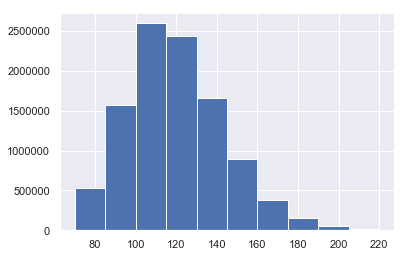

In [101]:
# look at distribution of systolic
_=plt.hist(df_BP2['systolic'])

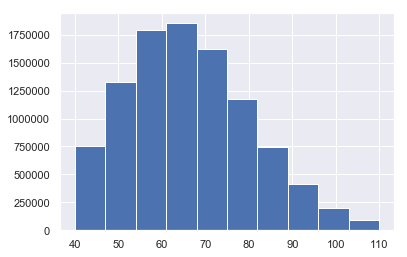

In [102]:
# look at distribution of diastolic
_=plt.hist(df_BP2['diastolic'])

In [103]:
df_BP2.head()

,ruid,systolic,diastolic,measure_date
0,50135262,150.0,80.0,01/09/2005
1,50135262,137.0,77.0,02/08/2007
2,50135262,137.0,78.0,02/08/2007
3,50135262,190.0,78.0,02/08/2007
4,50135262,190.0,77.0,02/08/2007


2) merge blood pressure data with base_table

In [104]:
df_BP2['measure_date'] = pd.to_datetime(df_BP2['measure_date'], infer_datetime_format=True, errors='coerce')

In [105]:
bp_merged = pd.merge(df_BP2,base_table[['ruid','visit_id','hospital_day']],how='outer',left_on=['ruid','measure_date'],right_on=['ruid','hospital_day'])

In [106]:
bp_merged.head()

,ruid,systolic,diastolic,measure_date,visit_id,hospital_day
0,50135262,150.0,80.0,2005-01-09,NaN,NaT
1,50135262,137.0,77.0,2007-02-08,0.0,2007-02-08
2,50135262,137.0,78.0,2007-02-08,0.0,2007-02-08
3,50135262,190.0,78.0,2007-02-08,0.0,2007-02-08
4,50135262,190.0,77.0,2007-02-08,0.0,2007-02-08


3) get median values of blood pressure values on ruid-visit_id combination

In [107]:
bp_median = bp_merged.groupby(['ruid','visit_id'])['systolic','diastolic'].median().reset_index()

In [108]:
bp_median.head()

,ruid,visit_id,systolic,diastolic
0,50135262,0.0,140.0,58.0
1,50135262,1.0,121.0,61.0
2,50135262,2.0,131.0,60.0
3,50135262,3.0,151.0,74.0
4,50135262,4.0,134.0,66.0


In [109]:
bp_median.columns = ['ruid','visit_id','systolic_median','diastolic_median']

In [110]:
bp_median.head()

,ruid,visit_id,systolic_median,diastolic_median
0,50135262,0.0,140.0,58.0
1,50135262,1.0,121.0,61.0
2,50135262,2.0,131.0,60.0
3,50135262,3.0,151.0,74.0
4,50135262,4.0,134.0,66.0


4) get 5th percentile for bps

In [111]:
sbp_5p = bp_merged.groupby(['ruid','visit_id'])['systolic'].apply(lambda x: np.nanpercentile(x, 5)).reset_index()

/anaconda3/envs/bios8366/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [112]:
sbp_5p.head()

,ruid,visit_id,systolic
0,50135262,0.0,107.0
1,50135262,1.0,106.0
2,50135262,2.0,108.0
3,50135262,3.0,116.0
4,50135262,4.0,122.0


In [113]:
dbp_5p = bp_merged.groupby(['ruid','visit_id'])['diastolic'].apply(lambda x: np.nanpercentile(x, 5)).reset_index()

In [114]:
dbp_5p.head()

,ruid,visit_id,diastolic
0,50135262,0.0,44.0
1,50135262,1.0,50.0
2,50135262,2.0,42.0
3,50135262,3.0,59.9
4,50135262,4.0,56.0


In [115]:
# merge the files
bp_5p = pd.merge(sbp_5p,dbp_5p,how='outer',on=['ruid','visit_id'])

In [116]:
bp_5p.head()

,ruid,visit_id,systolic,diastolic
0,50135262,0.0,107.0,44.0
1,50135262,1.0,106.0,50.0
2,50135262,2.0,108.0,42.0
3,50135262,3.0,116.0,59.9
4,50135262,4.0,122.0,56.0


In [117]:
bp_5p.columns = ['ruid','visit_id','systolic_5p','diastolic_5p']

In [118]:
bp_5p.head()

,ruid,visit_id,systolic_5p,diastolic_5p
0,50135262,0.0,107.0,44.0
1,50135262,1.0,106.0,50.0
2,50135262,2.0,108.0,42.0
3,50135262,3.0,116.0,59.9
4,50135262,4.0,122.0,56.0


In [119]:
bp_median.head()

,ruid,visit_id,systolic_median,diastolic_median
0,50135262,0.0,140.0,58.0
1,50135262,1.0,121.0,61.0
2,50135262,2.0,131.0,60.0
3,50135262,3.0,151.0,74.0
4,50135262,4.0,134.0,66.0


In [120]:
# merge with median data frame
bp_df = pd.merge(bp_median,bp_5p,how='outer',on=['ruid','visit_id'])

In [121]:
bp_df.head()

,ruid,visit_id,systolic_median,diastolic_median,systolic_5p,diastolic_5p
0,50135262,0.0,140.0,58.0,107.0,44.0
1,50135262,1.0,121.0,61.0,106.0,50.0
2,50135262,2.0,131.0,60.0,108.0,42.0
3,50135262,3.0,151.0,74.0,116.0,59.9
4,50135262,4.0,134.0,66.0,122.0,56.0


5) get 95th percentile values

In [122]:
sbp_95p = bp_merged.groupby(['ruid','visit_id'])['systolic'].apply(lambda x: np.nanpercentile(x, 95)).reset_index()

In [123]:
sbp_95p.head()

,ruid,visit_id,systolic
0,50135262,0.0,186.0
1,50135262,1.0,146.0
2,50135262,2.0,188.0
3,50135262,3.0,165.0
4,50135262,4.0,158.0


In [124]:
dbp_95p = bp_merged.groupby(['ruid','visit_id'])['diastolic'].apply(lambda x: np.nanpercentile(x, 95)).reset_index()

In [125]:
dbp_95p.head()

,ruid,visit_id,diastolic
0,50135262,0.0,77.0
1,50135262,1.0,74.0
2,50135262,2.0,82.0
3,50135262,3.0,88.0
4,50135262,4.0,88.0


In [126]:
# merge the files
bp_95p = pd.merge(sbp_95p,dbp_95p,how='outer',on=['ruid','visit_id'])

In [127]:
bp_95p.head()

,ruid,visit_id,systolic,diastolic
0,50135262,0.0,186.0,77.0
1,50135262,1.0,146.0,74.0
2,50135262,2.0,188.0,82.0
3,50135262,3.0,165.0,88.0
4,50135262,4.0,158.0,88.0


In [128]:
bp_95p.columns = ['ruid','visit_id','systolic_95p','diastolic_95p']

In [129]:
bp_95p.head()

,ruid,visit_id,systolic_95p,diastolic_95p
0,50135262,0.0,186.0,77.0
1,50135262,1.0,146.0,74.0
2,50135262,2.0,188.0,82.0
3,50135262,3.0,165.0,88.0
4,50135262,4.0,158.0,88.0


In [130]:
# merge with median data frame
bp_df = pd.merge(bp_df,bp_95p,how='outer',on=['ruid','visit_id'])

In [131]:
bp_df.head()

,ruid,visit_id,systolic_median,diastolic_median,systolic_5p,diastolic_5p,systolic_95p,diastolic_95p
0,50135262,0.0,140.0,58.0,107.0,44.0,186.0,77.0
1,50135262,1.0,121.0,61.0,106.0,50.0,146.0,74.0
2,50135262,2.0,131.0,60.0,108.0,42.0,188.0,82.0
3,50135262,3.0,151.0,74.0,116.0,59.9,165.0,88.0
4,50135262,4.0,134.0,66.0,122.0,56.0,158.0,88.0


6) get standard deviation at ruid-visit_id combination for bps

In [132]:
sbp_std = bp_merged.groupby(['ruid','visit_id'])['systolic'].apply(lambda x: np.std(x)).reset_index()

In [133]:
sbp_std.head()

,ruid,visit_id,systolic
0,50135262,0.0,20.263715
1,50135262,1.0,12.518349
2,50135262,2.0,25.989675
3,50135262,3.0,15.661763
4,50135262,4.0,11.855141


In [134]:
dbp_std = bp_merged.groupby(['ruid','visit_id'])['diastolic'].apply(lambda x: np.std(x)).reset_index()

In [135]:
dbp_std.head()

,ruid,visit_id,diastolic
0,50135262,0.0,9.868120
1,50135262,1.0,8.314473
2,50135262,2.0,10.976472
3,50135262,3.0,7.936733
4,50135262,4.0,11.269165


In [136]:
# merge the files
bp_std = pd.merge(sbp_std,dbp_std,how='outer',on=['ruid','visit_id'])

In [137]:
bp_std.head()

,ruid,visit_id,systolic,diastolic
0,50135262,0.0,20.263715,9.868120
1,50135262,1.0,12.518349,8.314473
2,50135262,2.0,25.989675,10.976472
3,50135262,3.0,15.661763,7.936733
4,50135262,4.0,11.855141,11.269165


In [138]:
bp_std.columns = ['ruid','visit_id','systolic_std','diastolic_std']

In [139]:
bp_std.head()

,ruid,visit_id,systolic_std,diastolic_std
0,50135262,0.0,20.263715,9.868120
1,50135262,1.0,12.518349,8.314473
2,50135262,2.0,25.989675,10.976472
3,50135262,3.0,15.661763,7.936733
4,50135262,4.0,11.855141,11.269165


In [140]:
# merge with base data frame
bp_df = pd.merge(bp_df,bp_std,how='outer',on=['ruid','visit_id'])

In [141]:
bp_df.head()

,ruid,visit_id,systolic_median,diastolic_median,systolic_5p,diastolic_5p,systolic_95p,diastolic_95p,systolic_std,diastolic_std
0,50135262,0.0,140.0,58.0,107.0,44.0,186.0,77.0,20.263715,9.868120
1,50135262,1.0,121.0,61.0,106.0,50.0,146.0,74.0,12.518349,8.314473
2,50135262,2.0,131.0,60.0,108.0,42.0,188.0,82.0,25.989675,10.976472
3,50135262,3.0,151.0,74.0,116.0,59.9,165.0,88.0,15.661763,7.936733
4,50135262,4.0,134.0,66.0,122.0,56.0,158.0,88.0,11.855141,11.269165


In [142]:
# merge with dataframe with labs, bmi, and pregnancy indicator
labs_merged_120718 = pd.read_csv(dir+'labs.csv',dtype={'ruid': str})

In [143]:
labs_merged_120718.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,mchc_std,mcv_std,na_std,pcv_std,plt-ct_std,rbc_std,rdw_std,wbc_std,bmi_last,pregnancy_indicator_last
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,0.000000,0.000000,0.000000,4.932883,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,0.100000,1.154701,2.217356,3.265986,30.692019,0.463609,0.300000,1.644182,45.27,0.0
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,0.424264,0.707107,0.000000,0.000000,13.000000,0.056569,0.353553,1.979899,47.06,0.0
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,0.234521,0.836660,2.408319,2.000000,25.347584,0.197358,0.389872,1.197915,47.14,0.0
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,0.353553,0.707107,1.414214,0.000000,16.970563,0.098995,0.141421,0.424264,47.58,0.0


In [144]:
labs_merged_120718 = pd.merge(labs_merged_120718,bp_df,how='outer',on=['ruid','visit_id'])

In [145]:
labs_merged_120718.head()

,ruid,visit_id,an-gap_median,bun_median,co2_median,ca_median,cl_median,creat_median,glubed_median,gluc_median,...,bmi_last,pregnancy_indicator_last,systolic_median,diastolic_median,systolic_5p,diastolic_5p,systolic_95p,diastolic_95p,systolic_std,diastolic_std
0,50135262,0,9.0,17.0,26.0,8.9,101.0,0.540,137.0,138.0,...,NaN,NaN,140.0,58.0,107.0,44.0,186.0,77.0,20.263715,9.868120
1,50135262,1,6.5,14.0,29.5,9.1,99.0,0.715,184.5,213.5,...,45.27,0.0,121.0,61.0,106.0,50.0,146.0,74.0,12.518349,8.314473
2,50135262,2,7.0,11.0,31.0,9.1,101.0,0.610,224.5,266.0,...,47.06,0.0,131.0,60.0,108.0,42.0,188.0,82.0,25.989675,10.976472
3,50135262,3,5.0,12.0,29.0,8.6,102.0,0.850,205.0,230.0,...,47.14,0.0,151.0,74.0,116.0,59.9,165.0,88.0,15.661763,7.936733
4,50135262,4,6.5,12.5,32.0,NaN,100.5,0.750,228.5,162.0,...,47.58,0.0,134.0,66.0,122.0,56.0,158.0,88.0,11.855141,11.269165


In [146]:
labs_merged_120718.to_csv(dir+'labs.csv',index=False)